### Project description:
#### Goals of analysis
* 1. Predict damage grade caused by earthquake using building characteristics/location data. 
* 2. “Based on aspects of building location and construction, our goal is to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal”

Following the 7.8 Mw Gorkha Earthquake on April 25, 2015, Nepal carried out a massive household survey using mobile technology to assess building damage in the earthquake-affected districts. Although the primary goal of this survey was to identify beneficiaries eligible for government assistance for housing reconstruction, it also collected other useful socio-economic information. In addition to housing reconstruction, this data serves a wide range of uses and users e.g. researchers, newly formed local governments, and citizens at large. 
Based on aspects of building location and construction, the goal is to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal.

#### Data description


The data was collected through surveys by the Central Bureau of Statistics that work under the National Planning Commission Secretariat of Nepal. This survey is one of the largest post-disaster datasets ever collected, containing valuable information on earthquake impacts, household conditions, and socio-economic-demographic statistics.                        

The raw dataset contains 762106 datapoints and consists of 3 files:                               
1.Structure Data: Contains structural information of the properties                             
2.Damage Data: Contains Damage assesment data of the prroperties.                                       
3.Ownership Data: Conntains geographical,legal data of the properties.                                       
                                                                                                

#### Data Source:

https://eq2015.npc.gov.np/#/

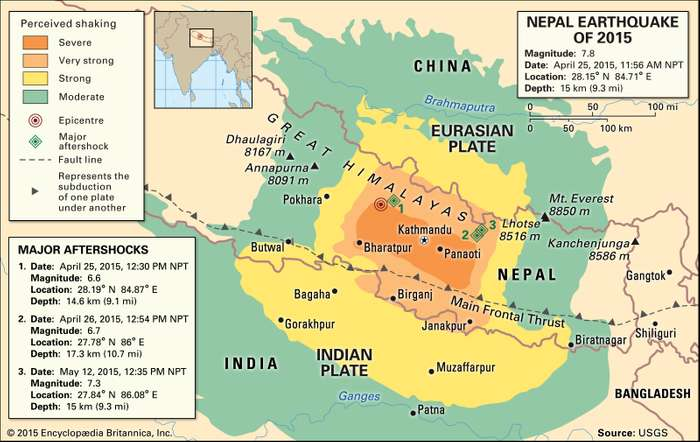

In [1]:
#Importing necessary Libraries
import pandas as pd
import numpy as np
import glob
import os
import missingno as msno
import collections
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from utils import *
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
BuildingPath      = "input_data/building_damage_assessment_building_ownership_and_use_building_structure/"
HouseholdPath     = "input_data/household_demographics_household_earthquake_impact_household_resources/"
IndividualPath    = "input_data/individual_demographics_individual_social_security/"

In [3]:
structure_data    =pd.read_csv(BuildingPath+'csv_building_structure.csv')
ownership_data    =pd.read_csv(BuildingPath+'csv_building_ownership_and_use.csv')
damage_data       =pd.read_csv(BuildingPath+'csv_building_damage_assessment.csv')
ward_mapping_data =pd.read_csv(BuildingPath+'ward_vdcmun_district_name_mapping.csv')

#### Feature removal:
* 'district_id', 'vdcmun_id', 'ward_id' are removed from structure file as these columns are repetitive.
* Also, removed post earthquake features from structure data.
* ownership file doesn't have post earthquake features

In [4]:
drop_structure_cols = ['count_floors_post_eq','height_ft_post_eq','condition_post_eq','district_id','vdcmun_id','ward_id', 'technical_solution_proposed']
structure_data.drop(drop_structure_cols, axis=1, inplace=True)

#### Merged structure data, ownership data files on 'building_id'.

In [5]:
structure_ownership_data = pd.merge(structure_data, ownership_data, on='building_id', how="inner")
structure_ownership_data.shape #shape of merged dataframe is same as original shape of unmerged dataframe

(762106, 40)

In [6]:
structure_ownership_data.columns

Index(['building_id', 'count_floors_pre_eq', 'age_building',
       'plinth_area_sq_ft', 'height_ft_pre_eq', 'land_surface_condition',
       'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type',
       'position', 'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'damage_grade', 'district_id', 'vdcmun_id', 'ward_id',
       'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_seco

#### Missing values in the following columns are:
* 'position' - 1
* 'plan_configuration' - 1
* 'damage_grade' - 12
* 'technical_solution_proposed' - 12
* 'count_families' - 2
* 'has_secondary_use' - 10

Missing data visualization is also done with msno package.

In [7]:
missing_data      = cal_missing_val(structure_ownership_data)
list_miss_columns = list(missing_data[missing_data['MissingValueInPercentage']>0.0].index)
print ("Missing value columns are :{}".format(list_miss_columns))

Missing value columns are :['position', 'plan_configuration', 'damage_grade', 'count_families', 'has_secondary_use']


In [8]:
print ("Number of NaN values per columns are below")
for col in list_miss_columns:
    count_ = collections.Counter(structure_ownership_data[col])
    print (col ,count_ )

Number of NaN values per columns are below
position Counter({'Not attached': 604453, 'Attached-1 side': 129432, 'Attached-2 side': 26910, 'Attached-3 side': 1310, nan: 1})
plan_configuration Counter({'Rectangular': 731257, 'Square': 17576, 'L-shape': 10079, 'T-shape': 969, 'Multi-projected': 940, 'Others': 518, 'U-shape': 448, 'E-shape': 140, 'Building with Central Courtyard': 98, 'H-shape': 80, nan: 1})
damage_grade Counter({'Grade 5': 275766, 'Grade 4': 183844, 'Grade 3': 136412, 'Grade 2': 87257, 'Grade 1': 78815, nan: 12})
count_families Counter({1.0: 643418, 0.0: 71576, 2.0: 39753, 3.0: 5685, 4.0: 1215, 5.0: 302, 6.0: 104, 7.0: 27, 8.0: 15, 9.0: 8, nan: 1, nan: 1, 11.0: 1})
has_secondary_use Counter({0.0: 669732, 1.0: 92364, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1})


#### Missing value imputation

* Used 'most_freuquent' method to impute category

In [9]:
impute_cols = ['position', 'plan_configuration']
for miss_col in impute_cols:
    structure_ownership_data[miss_col] = structure_ownership_data[miss_col].fillna(structure_ownership_data[miss_col].value_counts().idxmax())
    
structure_ownership_data['count_families'].fillna(np.nanmedian(structure_ownership_data['count_families']), inplace=True)

#### Data Cleaning

* Cleaned categorical data such as foundation_type, roof_type, ground_floor, other_floor, position, plan_configuration
* Removed rows where damage grade is null
* Remove buildings which have 'age_building' more than 900. 3145 buildings are removed. Possibility of that these are imputed values

In [10]:
cat_cols_to_clean = ['foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration']

for cat_col in cat_cols_to_clean:
    structure_ownership_data[cat_col] = structure_ownership_data[cat_col].apply(lambda x : replace_un_string(x))

In [11]:
structure_ownership_data = structure_ownership_data[pd.notnull(structure_ownership_data['damage_grade'])]
structure_ownership_data = structure_ownership_data[structure_ownership_data['age_building']<900]

In [12]:
structure_ownership_data.shape

(758950, 40)

#### Saving a file
Save file for analysis purpose.

In [13]:
structure_ownership_data.to_csv('clean_data/building_structure_ownership.csv', index=False)

#### Data Visualization

* damage_grade - distribution 
* correlation among structure_building data

In [14]:
building_99 = structure_ownership_data[pd.isnull(structure_ownership_data['damage_grade'])]

In [19]:
damage_dict          ={'Grade 3':'Grade 3', 'Grade 5':'Grade 4', 'Grade 2':'Grade 2', 'Grade 1':'Grade 1', 'Grade 4':'Grade 4'}
structure_ownership_data['damage_grade'] = structure_ownership_data['damage_grade'].map(damage_dict)

In [15]:
# sns.set_style('whitegrid')
# plt.rcParams['font.family'] = 'Dejavu Sans'
# plt.figure(figsize=(8,6))
# plt.title('Count of Damage Grade', fontsize=10)
# sns.countplot(x='damage_grade',data=structure_ownership_data,hue='damage_grade')
# plt.show()

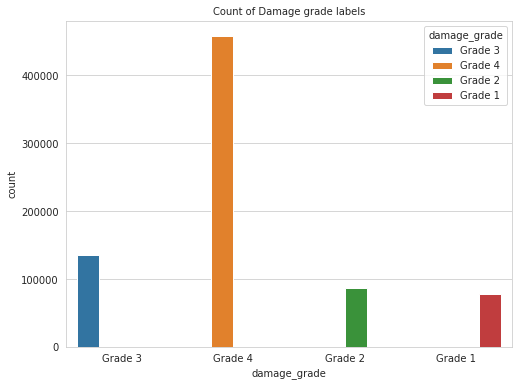

In [20]:
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'
plt.figure(figsize=(8,6))
plt.title('Count of Damage grade labels', fontsize=10)
sns.countplot(x='damage_grade',data=structure_ownership_data,hue='damage_grade')
plt.show()

In [17]:
structure_ownership_data['damage_grade'] = structure_ownership_data['damage_grade'].apply(lambda x : int(x.replace('Grade ', '')))

In [25]:
drop_cols = [ 'building_id', 'district_id', 'vdcmun_id', 'ward_id','other_floor_type','has_secondary_use_other', 'count_families', 
            ]
drop_cols =['has_secondary_use', 'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police']
structure_ownership_data.drop(drop_cols, axis=1, inplace=True)

In [26]:
structure_ownership_data.columns

Index(['count_floors_pre_eq', 'age_building', 'plinth_area_sq_ft',
       'height_ft_pre_eq', 'land_surface_condition', 'foundation_type',
       'roof_type', 'ground_floor_type', 'position', 'plan_configuration',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'damage_grade', 'legal_ownership_status',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel'],
      dtype='object')

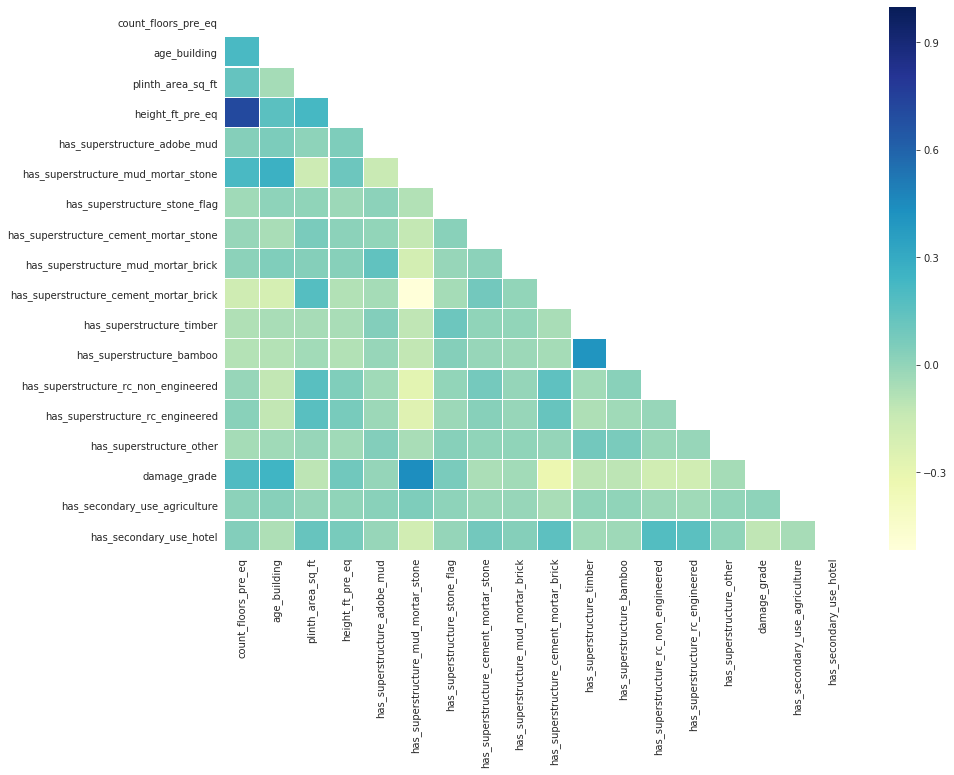

In [27]:
corrmat = structure_ownership_data.corr(method='spearman')
f,ax    = plt.subplots(figsize=(14,10))
mask    = np.triu(np.ones_like(corrmat, dtype=np.bool))
sns.heatmap(corrmat, mask=mask, ax=ax,cmap="YlGnBu", linewidths=0.1)

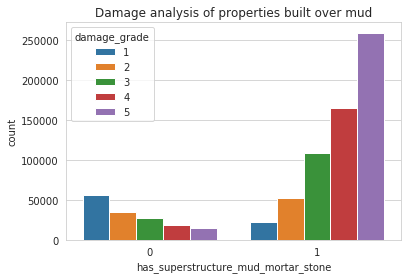

In [24]:
plt.title('Damage analysis of properties built over mud')
sns.countplot(x='has_superstructure_mud_mortar_stone',data=structure_ownership_data, hue='damage_grade')

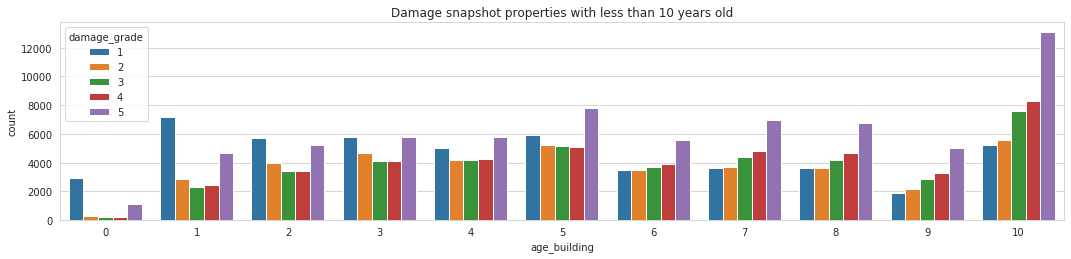

In [25]:
plt.figure(figsize=(18,8))
plt.subplot(211)
plt.title('Damage snapshot properties with less than 10 years old')
tr=structure_ownership_data[structure_ownership_data['age_building']<=10]
sns.countplot(x='age_building',data=tr,hue='damage_grade')

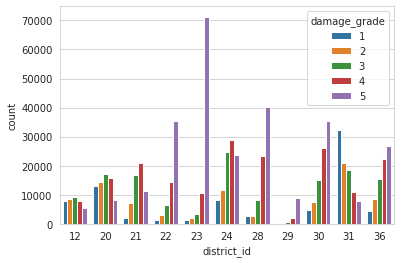

In [26]:
sns.countplot(x='district_id',data=structure_ownership_data,hue='damage_grade')

#### Damage assessment data understanding

In [27]:
damage_cols =[]
for col in damage_data.columns:
    if ('damage' in col):
        damage_cols.append(col)
damage_data  = damage_data[pd.notnull(damage_data['damage_grade'])]        
damage_data['damage_grade'] = damage_data['damage_grade'].apply(lambda x : int(x.replace('Grade ', '')))
damage_data_part  = damage_data[damage_cols]

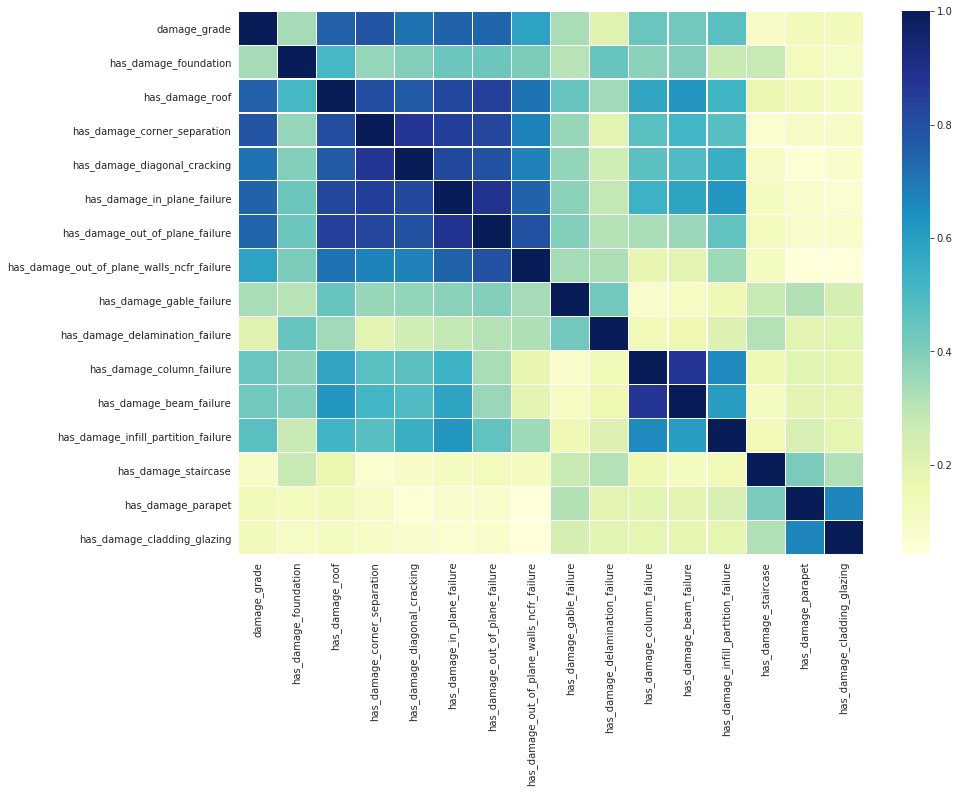

In [28]:
corrmat = damage_data_part.corr(method='pearson')
f,ax    = plt.subplots(figsize=(14,10))
sns.heatmap(corrmat,ax=ax,cmap="YlGnBu", linewidths=0.1)

* Good links

https://web.flowminder.org/case-studies/nepal-earthquake-2015

https://www.valuepenguin.com/earthquake-insurance

https://www.thebalance.com/earthquake-insurance-do-you-really-need-it-1969927

https://www.iii.org/article/earthquake-insurance-for-homeowners

https://www.amfam.com/insurance/home/earthquake-coverage?sourceid=_k_CjwKCAiAhJTyBRAvEiwAln2qBxScyARI5YxjEdvYzSZBn1s7vx8yohYRiPixyBuJnx-D4MR6DyghJBoC9r0QAvD_BwE_k_&gclid=CjwKCAiAhJTyBRAvEiwAln2qBxScyARI5YxjEdvYzSZBn1s7vx8yohYRiPixyBuJnx-D4MR6DyghJBoC9r0QAvD_BwE